In [167]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import animation
from IPython.display import HTML
import matplotlib
import random

# Preprocess data

For convenience, merge data files for all subjects into one file

In [168]:
def merge_txt_files(data_path='data'):
    dfs = []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.txt'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join('raw_data_merged.txt'), index=False, sep='\t')

merge_txt_files()

data\129_1_2019_10_01_10_17_fixed.txt
data\129_1_2019_10_01_10_32.txt
data\129_2_2019_10_01_14_06.txt
data\129_2_2019_10_01_14_18.txt
data\389_1_2019_10_02_10_22.txt
data\618_1_2019_10_01_09_13.txt
data\618_2_2019_10_02_09_06.txt
data\642_1_2019_10_01_17_28.txt


Response time (RT) is defined as the time between the momen the bot appeared in front of the subject (`idx_bot_spawn`) and the moment the subject pressed the acceleration pedal (`idx_throttle`)

In [164]:
traj_id = (129, 2, 5, 15)
traj = data.loc[traj_id]

idx_slowdown = (traj.ego_v<1.0).to_numpy().nonzero()[0][0]
bot_a_max = traj.bot_a.max()  
idx_bot_spawn = traj.bot_x.to_numpy().nonzero()[0][0]
#         idx_bot_spawn = idx_slowdown + (traj[idx_slowdown:].bot_a<0.1*bot_a_max).to_numpy().nonzero()[0][0]
throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
idx_response = idx_bot_spawn + (throttle>0).to_numpy().nonzero()[0][0]
RT = traj.t.values[idx_response] - traj.t.values[idx_bot_spawn]
idx_min_distance = idx_bot_spawn + np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
min_distance = min(traj.d_ego_bot[idx_bot_spawn:].values)

In [173]:
def get_measures(traj):
    '''
    This function extracts dependent variables and some other useful things from an individual trajectory.    
    The time of bot spawn is the first time bot_a is less than 10% of its max value (after the ego car slows
    down to 1 m/s). 
    '''
#     print(traj.name)
    
    if sum(traj.ego_v<1.0):
        idx_slowdown = (traj.ego_v<1.0).to_numpy().nonzero()[0][0]
        bot_a_max = traj.bot_a.max()  
        idx_bot_spawn = traj.bot_x.to_numpy().nonzero()[0][0]
#         idx_bot_spawn = idx_slowdown + (traj[idx_slowdown:].bot_a<0.1*bot_a_max).to_numpy().nonzero()[0][0]
        throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
        idx_response = idx_bot_spawn + (throttle>0).to_numpy().nonzero()[0][0]
        RT = traj.t.values[idx_response] - traj.t.values[idx_bot_spawn]
        idx_min_distance = idx_bot_spawn + np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
        min_distance = min(traj.d_ego_bot[idx_bot_spawn:].values)
    else:
        # if the driver never decelerated to <1m/s, the bot did not spawn
        idx_bot_spawn = -1
        idx_response = -1
        idx_min_distance = -1
        min_distance = -1
        RT = -1
    return pd.Series({'idx_bot_spawn': idx_bot_spawn,
                      'idx_response': idx_response,
                      'idx_min_distance': idx_min_distance,
                      'min_distance': min_distance,
                      'RT': RT})

def get_data(data_file='raw_data_merged.txt'):
    data = pd.read_csv(data_file, sep='\t', index_col=['subj_id', 'session', 'route', 'intersection_no'])
#     trials_to_exclude = [(618, 1, 1, 11), 
#                          (618, 1, 1, 12), 
#                          (618, 1, 1, 15), 
#                          (618, 1, 2, 10), 
#                          (618, 1, 2, 16),
#                          (618, 1, 3, 8),
#                          (618, 1, 3, 25),
#                          (618, 1, 4, 20),
#                          (618, 1, 4, 25),
#                          (642, 1, 1, 11)]
#     data = data.drop(trials_to_exclude)
    
    data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))
    
    # we are only intersted in left turns
    data = data[data.turn_direction==1]

    # only consider the data recorded within 10 meters of each intersection
    data = data[abs(data.ego_distance_to_intersection)<10]

    # smooth the time series by filtering out the noise using Savitzky-Golay filter
    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ['ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax', 'ego_ay', 
                      'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax', 'bot_ay']
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    # calculate absolute values of speed and acceleration
    data['ego_v'] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data['bot_v'] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)    
    data['ego_a'] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data['bot_a'] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)
    
    # calculate actual distance between the ego vehicle and the bot, and current tta for each t
    data['d_ego_bot'] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)    
    data['tta'] = data.d_ego_bot/data.bot_v
    
    # get the DVs and helper variables
    measures = data.groupby(data.index.names).apply(get_measures)
    
    data = data.join(measures)    
    
    # RT is -1 if a driver didn't stop and the bot did not appear at the intersection; we discard these trials
    data = data[data.RT>0]
    measures = measures[measures.RT>0]    
    
    # add the condition information to the measures dataframe for further analysis
    conditions = data.loc[:,['tta_condition', 'd_condition', 'v_condition']].groupby(data.index.names).first()
    measures = measures.join(conditions)
    
    return data, measures

In [170]:
measures.iloc[65:70]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     2       5     9                         47.0         147.0   
                      13                        54.0         366.0   
                      14                        60.0         460.0   
                      15                        51.0         129.0   
                      16                        48.0         349.0   

                                       idx_min_distance  min_distance  \
subj_id session route intersection_no                                   
129     2       5     9                           456.0     28.988425   
                      13                          450.0      3.554907   
                      14                          554.0      3.678289   
                      15                          450.0     22.165134   
                      16                          442.0      3.532101   

                                                                                      RT  \
subj_id session route intersection_no                                                      
129     2       5     9                                                            1.077   
                      13                                                          3.2553   
                      14                                                           4.163   
                      15               session  route  intersection_no
2        5    ...   
                      16                                                          3.1509   

                                       tta_condition  d_condition  \
subj_id session route intersection_no                               
129     2       5     9                          6.0        120.0   
                      13                         4.0         90.0   
                      14                         5.0         90.0   
                      15                         5.0        150.0   
                      16                         4.0         90.0   

                                       v_condition  is_turn_decision decision  
subj_id session route intersection_no                                          
129     2       5     9                       20.0              True     Turn  
                      13                      22.5             False     Wait  
                      14                      18.0             False     Wait  
                      15                      30.0              True     Turn  
                      16                      22.5             False     Wait

In [174]:
data, measures = get_data()

# is_turn_decision is calculated based on the minimum distance ever observed between ego and bot during the interaction.
# If the cars were no closer to each other than the lane width (3.5m + 1.5 margin), we count this as a turn decision.
# Based on visual inspection of animations for all trials, this works in all but one trials.
measures['is_turn_decision'] = measures.min_distance > 5

# In some trials this criterion wouldn't work, because e.g. a subject might hit a post after turning left, 
# so that the bot is less than 5m away from the ego car after the turn. We need to check this and fix manually
# measures.loc[(305, 1, 1, 8), ['is_turn_decision']] = True

# add column 'decision' for nicer visualization
measures['decision'] = 'Wait'
measures.loc[measures.is_turn_decision, ['decision']] = 'Turn'
measures_turn = measures[measures.is_turn_decision]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [175]:
measures.describe()

,idx_bot_spawn,idx_response,idx_min_distance,min_distance,RT,tta_condition,d_condition,v_condition
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,56.142450,233.524217,463.891738,14.384509,1.880528,5.000000,121.794872,25.004274
std,20.837938,143.413105,313.734300,16.395949,1.431670,0.817662,24.093226,6.377694
min,0.000000,26.000000,14.000000,1.689872,0.154000,4.000000,90.000000,15.000000
25%,45.000000,123.000000,420.000000,3.520118,0.783000,4.000000,90.000000,20.000000
50%,54.000000,164.000000,454.000000,3.882592,1.090200,5.000000,120.000000,24.000000
75%,66.000000,354.500000,529.500000,25.320797,3.147400,6.000000,150.000000,30.000000
max,142.000000,673.000000,5692.000000,102.909617,5.862700,6.000000,150.000000,37.500000


# Visualize decision dynamics

Let's take a look at the time course of an example "trial"

In [55]:
data

intersection_x  intersection_y  \
subj_id session route intersection_no                                   
129     1       1     5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
                      5                           450             300   
...                                               ...             ...   
618     1       4     24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24                          149             150   
                      24

In [56]:
traj_id = (129, 1, 1, 5)
traj = data.loc[traj_id]

In [57]:
def animate_traj(traj):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response) - idx_bot_spawn
    tta = traj.iloc[0].tta_condition
    d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
                 + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
    v = d/tta
    min_distance = traj.iloc[0].min_distance
    dt = traj.t.diff().median()  
    
    traj_to_plot = traj[idx_bot_spawn:]    
    
    fig, ax = plt.subplots()
    
    margin = 5
    ax.set_xlim(( min(traj_to_plot.ego_x.min(), traj_to_plot.bot_x.min()) - margin, 
                 max(traj_to_plot.ego_x.max(), traj_to_plot.bot_x.max()) + margin))
    ax.set_ylim(( min(traj_to_plot.ego_y.min(), traj_to_plot.bot_y.min()) - margin, 
                 max(traj_to_plot.ego_y.max(), traj_to_plot.bot_y.max()) + margin))  

    marker_ego, = ax.plot([], [], marker='o', ls='', color='C0', label='ego')
    marker_bot, = ax.plot([], [], marker='s', ls='', color='C1', label='bot')
    line_ego, = ax.plot([], [], lw=2, ls='-', color='C0')
    line_bot, = ax.plot([], [], lw=2, ls='-', color='C1')

    def animate(i):
        marker_ego.set_data(traj_to_plot.ego_x[i], traj_to_plot.ego_y[i])
        marker_bot.set_data(traj_to_plot.bot_x[i], traj_to_plot.bot_y[i])
        line_ego.set_data(traj_to_plot.ego_x[:i], traj_to_plot.ego_y[:i])
        line_bot.set_data(traj_to_plot.bot_x[:i], traj_to_plot.bot_y[:i])

        return (marker_ego, marker_bot, line_ego, line_bot,)
    
    legend = ax.legend(fontsize=12)
    ax.set_title('TTA=%.1fs, d=%im, v=%.2fm/s, min_d=%.1fm' % (tta, d, v, min_distance), fontsize=14)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(traj_to_plot), interval=int(1000*dt), blit=True)
    return anim

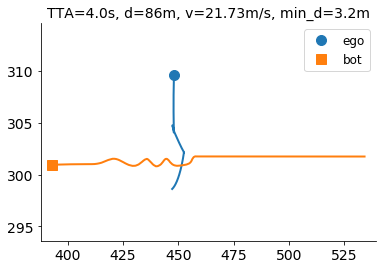

In [58]:
anim = animate_traj(traj)
HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

Let's take a look at the time course of the trials to see if the times of bot spawn (start of decision) and response (termination of a decision) are determined correctly

In [66]:
def plot_traj(traj, fig_path='figures'):    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color='C0')
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color='C7', ls='', marker='x')
    axes[0].set_ylabel('ego v')

    axes[1].plot(traj.t, traj.throttle, color='C1')
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color='C7', ls='', marker='x')
    axes[1].set_ylabel('ego throttle')

    axes[2].plot(traj.t[:], traj.d_ego_bot[:], color='C2')
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color='C7', ls='', marker='x')
    axes[2].set_ylabel('d(ego to bot)')

    axes[3].plot(traj.t[:], traj.tta[:], color='C3')
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color='C7', ls='', marker='o', 
                 label='Oncoming car appears')
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color='C7', ls='', marker='x', 
                 label='Decision is made')
    axes[3].set_ylabel('tta')
    axes[3].set_ylim((0, 7))

    axes[3].set_xlabel('time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(1.0, 0.9), 
                        title=str(traj.iloc[0].name) + '\nTTA=%.1fs, d=%im' % (tta, d))
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, '%s.png' % (str(traj.iloc[0].name))))

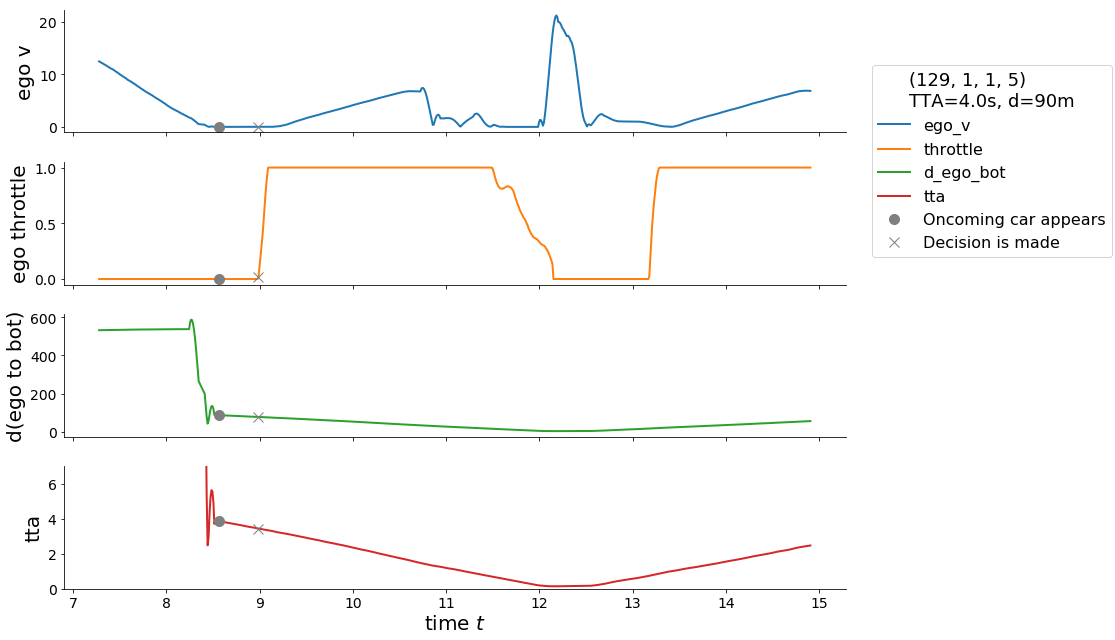

In [67]:
plot_traj(traj)

To check whether the algorithms of detecting 1) determining whether a driver decided to turn or to wait, 2) the momement the decision started (bot spawned), and 3) the moment decision was made, we save animations and time series plots for all trials

In [19]:
for name, traj in data[data.min_distance<5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/wait/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plot_traj(traj, 'figures/wait')
    plt.close()

In [20]:
for name, traj in data[data.min_distance>5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/turn/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plot_traj(traj, 'figures/turn')
    plt.close()

Visual inspection of all trials confirmed that the chosen algorithms accurately detect turn/wait decisions and response times. The only exception are response times in the trials where a subject started moving away but then changed their mind and decided to wait in the end. These RTs are short, although the decision is "wait"

In [68]:
measures[(measures.RT<1) & (measures['decision']=='Wait')]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     1       1     5                        120.0         161.0   
                      8                         50.0          87.0   
                      14                         3.0          68.0   
                      22                        59.0         122.0   
                2     2                         94.0         137.0   
                      3                         64.0         120.0   
                      13                        44.0         123.0   
                      14                        41.0          98.0   
                      25                        79.0         148.0   
                4     20                        80.0         140.0   
618     1       1     14                        67.0         107.0   
                      20                        83.0         160.0   
                      22                         2.0          73.0   
                2     3                         46.0         126.0   
                      25                       101.0         151.0   
                3     4                         77.0         124.0   
                      24                       128.0         164.0   
                4     4                         85.0         130.0   
                      12                        75.0         134.0   
                      19                        79.0         135.0   

                                       idx_min_distance  min_distance      RT  \
subj_id session route intersection_no                                           
129     1       1     5                           471.0      3.226016  0.4218   
                      8                           506.0      3.234011  0.3820   
                      14                          393.0      3.625540  0.7272   
                      22                          527.0      3.200380  0.6493   
                2     2                           465.0      3.191600  0.4431   
                      3                           533.0      3.554495  0.5766   
                      13                          629.0      3.389792  0.8654   
                      14                          411.0      3.622424  0.5863   
                      25                          452.0      3.247388  0.7095   
                4     20                          449.0      3.735734  0.6183   
618     1       1     14                          532.0      3.579906  0.4121   
                      20                          552.0      3.595730  0.7925   
                      22                          471.0      3.735560  0.8305   
                2     3                           420.0      3.376384  0.8228   
                      25                          467.0      3.586847  0.5142   
                3     4                           629.0      3.537807  0.4826   
                      24                          676.0      3.242720  0.3718   
                4     4                           456.0      2.903305  0.4626   
                      12                          444.0      3.520742  0.6063   
                      19                          440.0      3.467782  0.5758   

                                       tta_condition  d_condition  \
subj_id session route intersection_no                               
129     1       1     5                          4.0         90.0   
                      8                          5.0         90.0   
                      14                         4.0        150.0   
                      22                         5.0        120.0   
                2     2                          4.0        150.0   
                      3                          5.0        150.0   
                      13                         6.0        120.0   
                      14                         4.0        150.0   
                      25 

For instance, this one

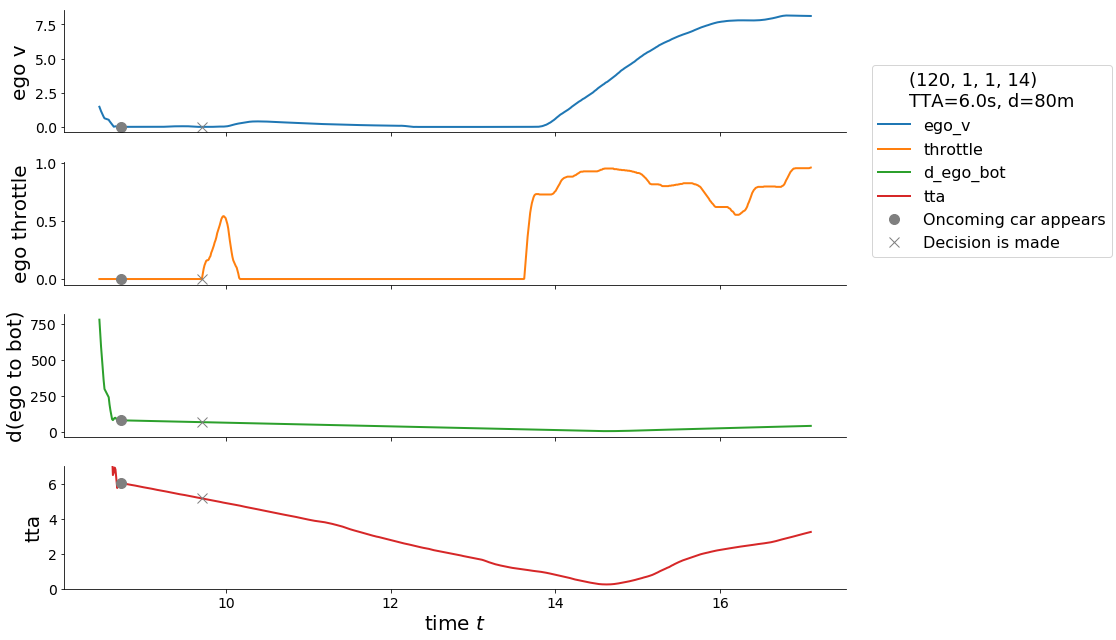

In [51]:
plot_traj(data.loc[random.choice(measures[(measures.RT<1) & (measures['decision']=='Wait')].index)])

In future, we will update the RT detection algorithm so that it ignores small movements of the car due to short presses of the gas pedal. These changes-of-mind will also be interesting to model, possibly using the extension of the DDM model by Resulaj et al (2009)

In [176]:
measures = measures.reset_index()
measures_turn = measures_turn.reset_index()

# Effect of TTA on decision and RT

With the exception of subject 642, probability of turning increases with time gap

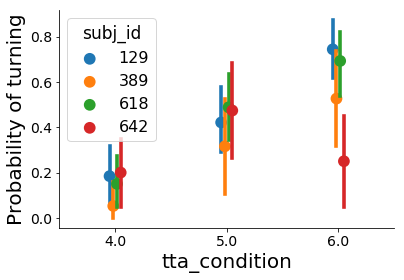

In [177]:
ax = sns.pointplot(data=measures, x='tta_condition', y='is_turn_decision', hue='subj_id', join=False, dodge=0.1)
ax.set_ylabel('Probability of turning');

Now let's see if there are any abnormalities in the RTs. We could already see in some trials that in "wait" decisions RT is very short because of "changes-of-mind", but also people would often start pressing the gas pedal before the oncoming car passes, so RT are usually less than TTA. So far we focus on the "turn" decisions, so we can ignore "wait" RTs altogether. Still, it's intersting to see RTs for all trials (but bear in mind that some "wait" trials will have weird RTs)

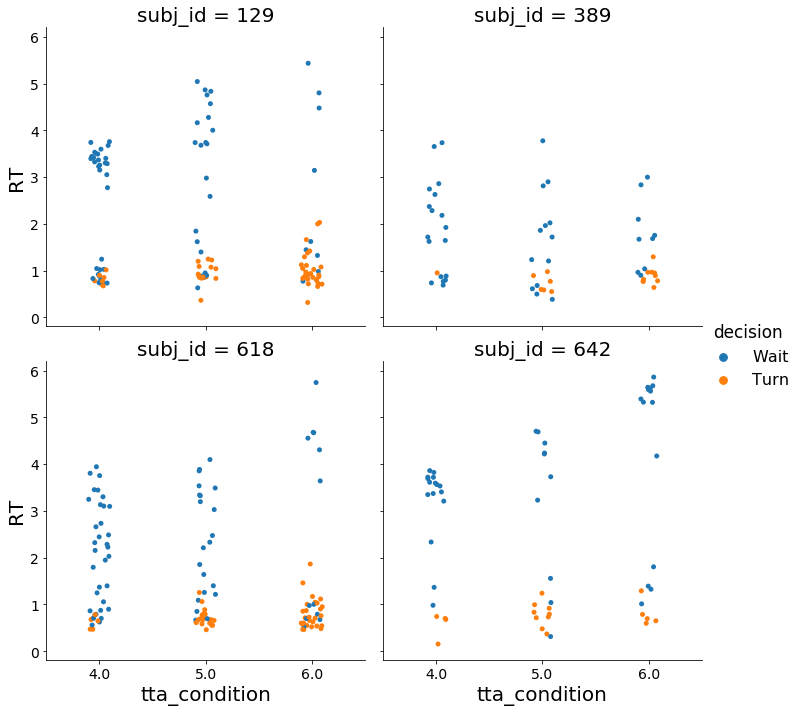

In [203]:
grid = sns.catplot(data=measures, x='tta_condition', y='RT', col='subj_id', col_wrap=2, hue='decision')

Zooming in on the 'turn' decisions, we look at RTs as a function of TTA. For all subjects, RT increases with TTA 

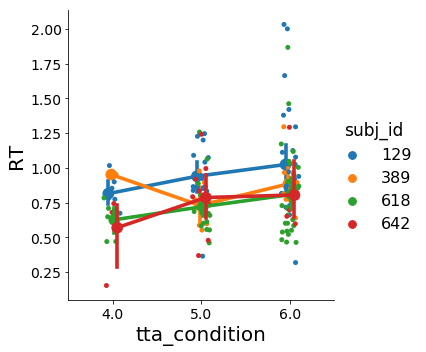

In [179]:
grid = sns.catplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id', ax=ax, alpha=0.5, dodge=0.1)
# ax.set_ylim((-0.05, 1.2))
ax.legend().remove()

Interestingly, we have a positive relationship between RT and TTA condition, which isn't what would be predicted by the constant-drift-rate DDM. The latter implies that for low-probability decisions we have longest response times, while we see the opposite picture. Is that because the drift rate in our case decreases with time? Or because TTA is not the primary perceptual variable used by the drivers?

# Effect of distance on decision and RT

As expected, probability of turning also increases with distance

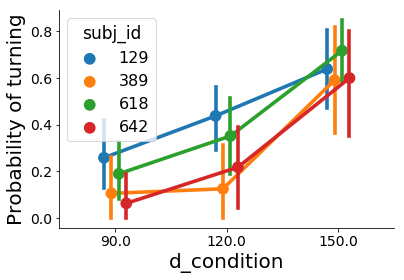

In [182]:
ax = sns.pointplot(data=measures, x='d_condition', y='is_turn_decision', hue='subj_id', join=True, dodge=0.2)
ax.set_ylabel('Probability of turning');

Interestingly though, RT seems to decrease with distance in general (although the difference between 120 and 150 is not that clear) 

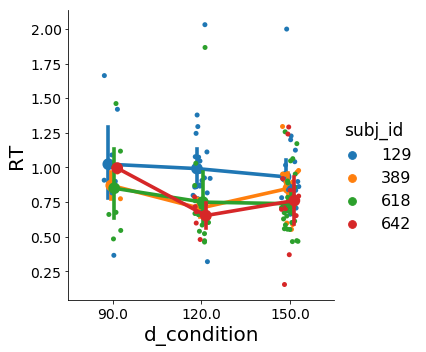

In [195]:
grid = sns.catplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id', ax=ax, alpha=0.5, dodge=0.1)
ax.legend().remove()

# Aggregate data for all subjects

Let's aggregate the data for all subjects, given that the patterns seem to be fairly consistent across the sample so far.

This is just to illustrate that probability of turning increases with both distance and TTA.

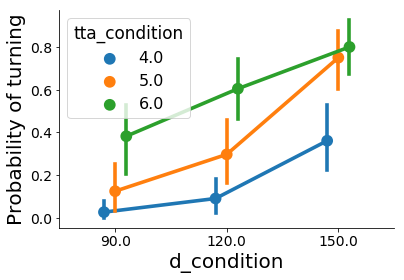

In [186]:
ax = sns.pointplot(data=measures, x='d_condition', y='is_turn_decision', hue='tta_condition', join=True, dodge=0.2)
ax.set_ylabel('Probability of turning');

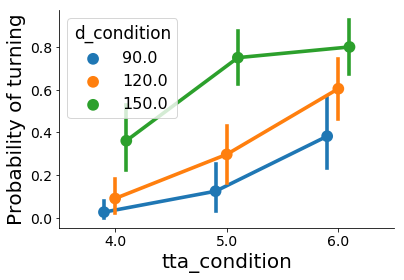

In [204]:
ax = sns.pointplot(data=measures, x='tta_condition', y='is_turn_decision', hue='d_condition', join=True, dodge=0.2)
ax.set_ylabel('Probability of turning');

It's interesting how difference between 90 and 120 meters is less than difference between 120 and 150 across all TTAs.  At the same time, difference between TTA=4 and TTA=5 is small at 90 meters, but is very large at 150 meters; this is reversed for difference between TTA=5 and TTA=6.

Aggregated data shows also that RT increases with TTA 

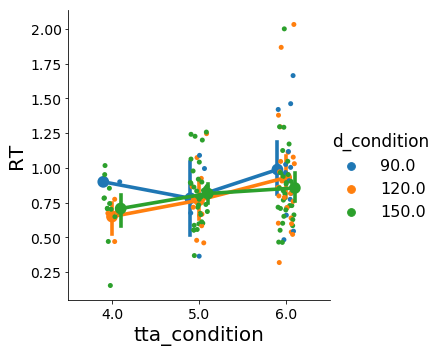

In [197]:
grid = sns.catplot(data=measures_turn, x='tta_condition', y='RT', hue='d_condition')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='tta_condition', y='RT', hue='d_condition', ax=ax, alpha=0.1, dodge=0.2)
ax.legend().remove()

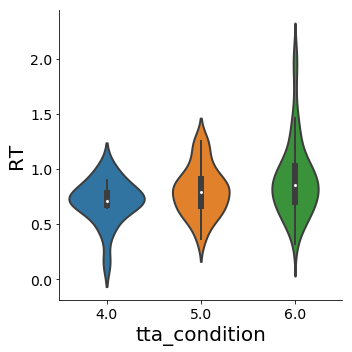

In [200]:
sns.catplot(data=measures_turn, x='tta_condition', y='RT', kind='violin')

But at the same time RT *decreases* with distance!

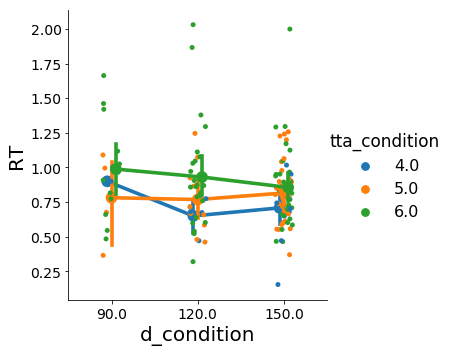

In [198]:
grid = sns.catplot(data=measures_turn, x='d_condition', y='RT', hue='tta_condition')
ax = grid.axes[0][0]
sns.pointplot(data=measures_turn, x='d_condition', y='RT', hue='tta_condition', ax=ax, alpha=0.5, dodge=0.1)
ax.legend().remove()

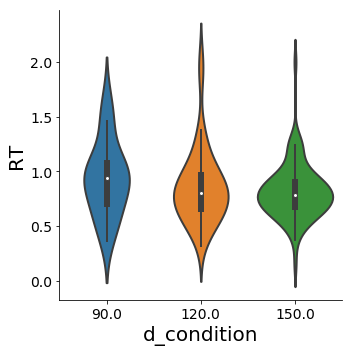

In [201]:
sns.catplot(data=measures_turn, x='d_condition', y='RT', kind='violin')